# Quantifying optical microscopy images for phase fraction estimation

# Importing libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout

# Reading and visualizing data file

(465, 600)


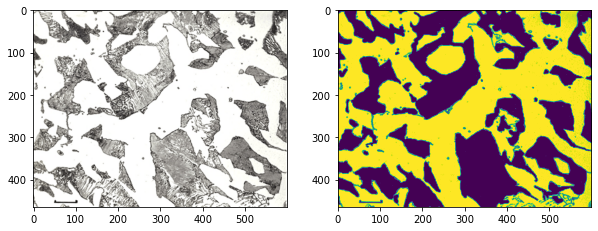

In [2]:
img = Image.open('img3.gif')
mask = Image.open('img3-mask.gif').convert('L') 
img_array = np.array(img)
print(img_array.shape)
mask_array = np.array(mask)

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mask)

plt.show()

# Data pre processing

# Division of image and mask into 25 smaller images

In [3]:
for i in range(5):
    for j in range(5):
        k = img_array[93*i:93*i+93, 120*j:120*j+120]
        l = mask_array[93*i:93*i+93, 120*j:120*j+120]
        im1 = Image.fromarray(k)
        im2 = Image.fromarray(l)
        im1.save('img_'+str(i)+'_'+str(j)+'.jpg')
        im2.save('mask_'+str(i)+'_'+str(j)+'.jpg')

# Conversion of images and masks to grayscale, resizing to 128*128 and rescaling of pixel values to the range 0-1.

In [4]:
images = []
for i in os.listdir():
    if i[:4] == 'img_':
        #print(i)
        temp_img = Image.open(i).convert('L') 
        temp_img = temp_img.resize((128,128))
        temp_img_array = np.array(temp_img)/255
        #print(temp_img_array.shape)
        images.append(temp_img_array)

masks = []
for l in os.listdir():
    if l[:4] == 'mask':
        tmask = Image.open(l).convert('L')
        tmask = tmask.resize((128,128))
        tmaskarr = np.array(tmask)
        for i in range(tmaskarr.shape[0]):
            for j in range(tmaskarr.shape[1]):
                if tmaskarr[i][j]<230:
                    tmaskarr[i][j] = 1
                else:
                    tmaskarr[i][j] = 0
        masks.append(tmaskarr)

# Data visualization

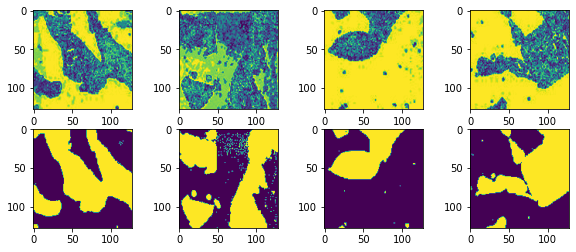

In [5]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(2,4,1)
ax1.imshow(images[0])
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(images[4])
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(images[8])
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(images[11])
ax5 = fig.add_subplot(2,4,5)
ax5.imshow(masks[0])
ax5 = fig.add_subplot(2,4,6)
ax5.imshow(masks[4])
ax5 = fig.add_subplot(2,4,7)
ax5.imshow(masks[8])
ax5 = fig.add_subplot(2,4,8)
ax5.imshow(masks[11])
plt.show()

# Data prep for training

In [6]:
X_train = np.array(images[:20])
y_train = np.array(masks[:20])
X_train = X_train.reshape(20, 128, 128, 1)
y_train = y_train.reshape(20, 128, 128, 1)
X_test = np.array(images[20:])
y_test = np.array(masks[20:])
X_test = X_test.reshape(5, 128, 128, 1)
y_test = y_test.reshape(5, 128, 128, 1)

In [7]:
IMG_HEIGHT = 128
IMG_WIDTH  = 128
IMG_CHANNELS = 1

# Building model

In [8]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [9]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 48  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  6928        ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_8 (Dropout)            (None, 128, 128, 16  0           ['conv2d_16[0][0]']              
          

# Model training

In [10]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

#model.save('microstructure_quantification.hdf5')

Epoch 1/50
2/2 [==============================] - 4s 770ms/step - loss: 0.6576 - accuracy: 0.5400 - val_loss: 0.6518 - val_accuracy: 0.4236
Epoch 2/50
2/2 [==============================] - 2s 474ms/step - loss: 0.5547 - accuracy: 0.5715 - val_loss: 0.6250 - val_accuracy: 0.4296
Epoch 3/50
2/2 [==============================] - 2s 476ms/step - loss: 0.5056 - accuracy: 0.5913 - val_loss: 0.5510 - val_accuracy: 0.5557
Epoch 4/50
2/2 [==============================] - 2s 456ms/step - loss: 0.4390 - accuracy: 0.7221 - val_loss: 0.4754 - val_accuracy: 0.7970
Epoch 5/50
2/2 [==============================] - 2s 451ms/step - loss: 0.3823 - accuracy: 0.8555 - val_loss: 0.5162 - val_accuracy: 0.7534
Epoch 6/50
2/2 [==============================] - 2s 504ms/step - loss: 0.3401 - accuracy: 0.8611 - val_loss: 0.5674 - val_accuracy: 0.7033
Epoch 7/50
2/2 [==============================] - 2s 475ms/step - loss: 0.3631 - accuracy: 0.8395 - val_loss: 0.3720 - val_accuracy: 0.8959
Epoch 8/50
2/2 [====

# Model testing

In [11]:
ypred = model.predict((X_test))
ypred = ypred.reshape(5, 128, 128)

1/1 [==============================] - 0s 351ms/step


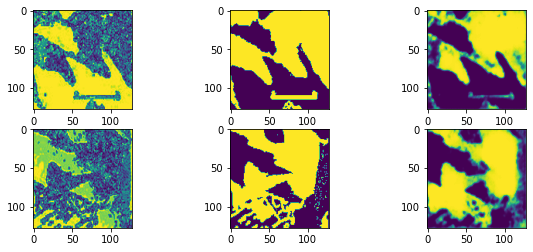

In [12]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(X_test[0])
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(y_test[0])
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(ypred[0])

ax4 = fig.add_subplot(2,3,4)
ax4.imshow(X_test[-1])
ax5 = fig.add_subplot(2,3,5)
ax5.imshow(y_test[-1])
ax6 = fig.add_subplot(2,3,6)
ax6.imshow(ypred[-1])